<a href="https://www.kaggle.com/code/handandegerli/model-based-coll-fil-matrix-factorization?scriptVersionId=182592360" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install surprise

In [2]:
#############################
# Model-Based Collaborative Filtering: Matrix Factorization
#############################
 
import pandas as pd
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
pd.set_option('display.max_columns', None)

# Adım 1: Veri Setinin Hazırlanması
# Adım 2: Modelleme
# Adım 3: Model Tuning
# Adım 4: Final Model ve Tahmin

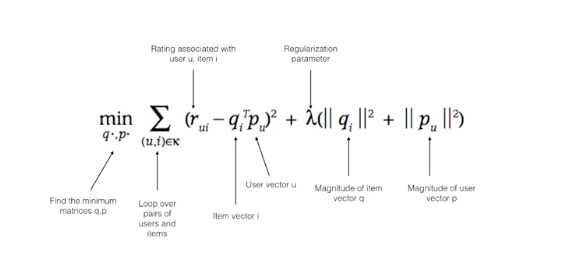

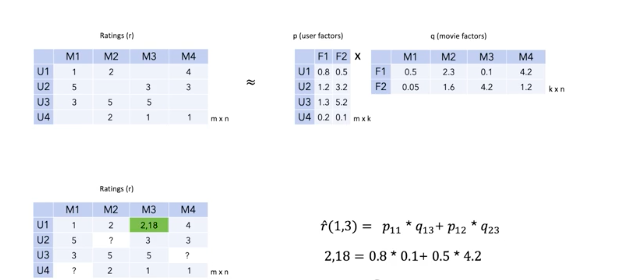

In [3]:
#############################
# Adım 1: Veri Setinin Hazırlanması
#############################

movie = pd.read_csv('/kaggle/input/dataset-for-mbcr/movie.csv')
rating = pd.read_csv('/kaggle/input/dataset-for-mbcr/rating.csv')
df = movie.merge(rating, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


In [4]:
movie_ids = [130219, 356, 4422, 541]
movies = ["The Dark Knight (2011)",
          "Cries and Whispers (Viskningar och rop) (1972)",
          "Forrest Gump (1994)",
          "Blade Runner (1982)"]

sample_df = df[df.movieId.isin(movie_ids)]
sample_df.head()


,movieId,title,genres,userId,rating,timestamp
2457839,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.0,4.0,1996-08-24 09:28:42
2457840,356,Forrest Gump (1994),Comedy|Drama|Romance|War,7.0,4.0,2002-01-16 19:02:55
2457841,356,Forrest Gump (1994),Comedy|Drama|Romance|War,8.0,5.0,1996-06-05 13:44:19
2457842,356,Forrest Gump (1994),Comedy|Drama|Romance|War,9.0,4.0,2001-07-01 20:26:38
2457843,356,Forrest Gump (1994),Comedy|Drama|Romance|War,10.0,3.0,1999-11-25 02:32:02


In [5]:
sample_df.shape

(97343, 6)

In [6]:
user_movie_df = sample_df.pivot_table(index=["userId"],
                                      columns=["title"],
                                      values="rating")

In [7]:
user_movie_df.shape

(76918, 4)

In [8]:
#skalamızı bildiriyoruz ona gore hesaplama yapması için
reader = Reader(rating_scale=(1, 5))

In [9]:
#model bize sesleniyor :)
#bu df i benim anlayabileceğim bir veri yapısına çevirmen lazım! 
#Özel veri yapım var bu methodu kullanmanı istiyorum. 

data = Dataset.load_from_df(sample_df[['userId',
                                       'movieId',
                                       'rating']], reader)

In [10]:
#modelleri belirli bir egitim üzerinde kurup daha sonra modelin gormediği bir test seti üzerinden test ederiz.


In [11]:
##############################
# Adım 2: Modelleme
##############################
#scikitlearn değil surprise üzerinden data yı  train ve test split methodu ile yaparız.
trainset, testset = train_test_split(data, test_size=.25)

#model nesnesini getiririz. matris fact yontemini kullanıcagımız fonkdur. SVD
svd_model = SVD()

#model kurduk train üzerinden
svd_model.fit(trainset)

#test seti üzerinde tahminleri sor
predictions = svd_model.test(testset)

In [12]:
#hataların hesaplamasını yapıyoruz.
#r-tahmin nin farkının karesinin toplamının ortalamasının karekokunu alırız.
accuracy.rmse(predictions)

RMSE: 0.9354


0.9353824109139901

In [13]:
svd_model.predict(uid=1.0, iid=541, verbose=True)

svd_model.predict(uid=1.0, iid=356, verbose=True)

user: 1.0        item: 541        r_ui = None   est = 4.17   {'was_impossible': False}
user: 1.0        item: 356        r_ui = None   est = 4.07   {'was_impossible': False}


Prediction(uid=1.0, iid=356, r_ui=None, est=4.06508604150934, details={'was_impossible': False})

In [14]:
sample_df[sample_df["userId"] == 1]

,movieId,title,genres,userId,rating,timestamp
3612352,541,Blade Runner (1982),Action|Sci-Fi|Thriller,1.0,4.0,2005-04-02 23:30:03


In [15]:
#modeli optimize etmek: modelin tahmin performansını artırmaya calısmaktır.
#burada modelin kullanıcı tarafından ayarlanabilir 
#hiper parametreleri nasıl optimize etmemiz gerektiğine bakacagız.
#epocs sayısı: iterasyon sayısı bu bir dıssal parametre ya kullanıcı ta verilmeli ya da optimize edilmeli

##############################
# Adım 3: Model Tuning
##############################

param_grid = {'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005, 0.007]}

#['rmse', 'mae'] bu metricler ac gosterim yapılır. ilki hata karelerinin karekoku ikincisi mutlak değerinin hata ortalaması(mutlak degeri)
#capraz dogulama demek cv, modeli üçe bol iki parcasıyla egıt sonra kalanıyla test et aynı işlemi diğer iki parça için de yap ve ort al
#işlemcileri full performans ile kul n_jobs=-1,
#işlem ger bana raporlama yap demek joblib_verbose=True
gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=3,
                  n_jobs=-1,
                  joblib_verbose=True)

gs.fit(data)

gs.best_score['rmse']
gs.best_params['rmse']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.6s finished


{'n_epochs': 5, 'lr_all': 0.005}

In [16]:
##############################
# Adım 4: Final Model ve Tahmin
##############################

#dir(svd_model)
#svd_model.n_epochs

#svd_model = SVD(**gs.best_params['rmse'])

#data = data.build_full_trainset()
#svd_model.fit(data)

#svd_model.predict(uid=1.0, iid=541, verbose=True)